<h1 align="center">Individual Assignment: Where will poverty next surge? </h1> <br>

An investigative analysis into predicting poverty to speed up actions that can be taken to alleviate it.

<img src="https://i.guim.co.uk/img/media/2a30a6e19df8d3146efad846d305e49aa4a2f1f3/21_488_3969_2382/master/3969.jpg?width=1200&height=900&quality=85&auto=format&fit=crop&s=05ce7c207fedf467d6eb1a32a644cb45"><br><br>

## Table of Content<br><br>


**`1.Data Preparation`**<br>
- 1.1. [Context & Application](#Context)<br>
- 1.2. [Library & Data Import](#Library_&_data_import)<br>
- 1.3. [Data Inspection & Cleaning](#Data_Inspection&Cleaning)<br> 

**`2.Exploratory Analysis`**<br>
- 2.1. [Generic Inspection](#GenericInspection)<br>
- 2.2. [Inspection of Sample Demographics](#InspectionofSampleDemographics)<br>
- 2.3. [Poverty Risk Assessment](#PovertyRiskAssessment)<br>

**`3.Feature Engineering`**<br>
- 3.1. [Capability Score](#CapabilityScore)<br>
- 3.2. [Digital Access Score](#DigitalAccessScore)<br>
- 3.3. [Savings Score](#SavingsScore)<br>
- 3.4. [Borrowings Score](#BorrowingsScore)<br>

**`4.Data Transformation & Pre-Processing`**<br>
- 4.1. [Numeric Feature Transformation](#NumFeatureEngineering)<br>
- 4.2. [Feature Selection](#FeatureSelection)<br>
- 4.3. [Final Checks](#FinalChecks)<br>

**`5.Model Implementation, Evaluation & Improvement`**<br>
- 5.1. [Model Implementation & Initial Evaluation](#ModelImplementation)<br>
- 5.2. [Improvement: Hyper Parameter Tuning](#HyperParameterTuning)<br>
- 5.3. [Ensemble Modelling & Final Evaluation](#EnsembleModelling)<br>

**`6.Result & Implications`**<br>
- 6.1. [Limitations](#Limitations)<br>
- 6.2. [Implications](#Implications)<br>

In [143]:
# Wordcount
import io
from nbformat import current
######################## Input your pathfile here:#######################
with io.open("/Users/carina/Desktop/UCL_MSc Business Analytics/02_Courses/02_Term 2/Predictive Analytics/Individual Coursework/Predictive Analytics Individual Coursework_vF.ipynb", 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print(word_count)

2000


# 1. Data Preparation
### 1.1. Context & Application
<a id="Context"></a>

Data on poverty proves important in optimising resource allocation and establishing strategic priorities. The data provides communities with the opportunity to evaluate goals and targets. It is exactly such data, that allowed researchers to evaluate that the world would not achieve the United Nation's (UN) goal of [Zero Hunger by 2030](https://www.un.org/sustainabledevelopment/hunger/) for example. Rather the data showed that cases of hunger had risen again in 2015. The time-consuming, costly and tedious nature to gathering large amounts of recent data  is fortified by the difficulty of making the data more comparable to derive insights from it. Lack of financial resources, political instability or violence at times even render data collection impossible, and even if possible, the time it takes to collect, process and evaluate the data might result in years of lag, before the data is usable.<br>
<br>
Given the fast-paced environment of today, predicting the probability of individuals living below a certain poverty line, based on socioeconomic indicators, serves political institutions, researches and the community as a whole. The algorithm developed may be continuously fed with more information, to provide the most reliable and accurate results possible.
<br>

### 1.2 Library & Data Import 
<a id="Library&DataImport"></a>

In [ ]:
# Dataset Source: https://www.kaggle.com/johnnyyiu/predicting-poverty

In [44]:
# Importing generic libraries
import os
import time
import math
import numpy as np
import pandas as pd
from scipy import stats
import pandas_profiling
from pprint import pprint
from scipy.stats import norm
from collections import OrderedDict

# Importing ML models
import lightgbm as lgb
import xgboost as xgb

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score, accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.exceptions import DataConversionWarning
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

# Importing visusalisation tools
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import plotly_express as px
import matplotlib.pyplot as plt

from yellowbrick.datasets import load_concrete
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import ResidualsPlot,residuals_plot

%matplotlib inline
cmaps = OrderedDict()

# Allowing multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Allowing to see all of our columns or rows in jupyter notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Setting code up so that it doesn't display scientific notation, we want full numbers
pd.set_option('display.float_format', '{:.2f}'.format)

In [45]:
# Setting colours to be used for visualisations
colours = ["cornflowerblue", "coral", "sandybrown", "lightseagreen"]

In [46]:
######################## Input your pathfile here:#######################
# Loading our data in
train = pd.read_csv('/Users/carina/Desktop/UCL_MSc Business Analytics/02_Courses/02_Term 2/Predictive Analytics/Individual Coursework/archive/train_values.csv')
labels = pd.read_csv('/Users/carina/Desktop/UCL_MSc Business Analytics/02_Courses/02_Term 2/Predictive Analytics/Individual Coursework/archive/train_labels.csv')
test = pd.read_csv('/Users/carina/Desktop/UCL_MSc Business Analytics/02_Courses/02_Term 2/Predictive Analytics/Individual Coursework/archive/test_values.csv')

# Adding labels to train data
data = pd.merge(train, labels)
                
# Creating distinguising flags for test and train set as only trainset contains poverty probability indicators
test['testflag'] = 1


# Inspecting data
data.describe()
test.describe()

,row_id,age,education_level,share_hh_income_provided,num_times_borrowed_last_year,borrowing_recency,bank_interest_rate,mm_interest_rate,mfi_interest_rate,other_fsp_interest_rate,num_shocks_last_year,avg_shock_strength_last_year,phone_technology,phone_ownership,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,poverty_probability
count,12600.00,12600.00,12364.00,12295.00,12600.00,12600.00,289.00,151.00,201.00,239.00,12600.00,12600.00,12600.00,12600.00,12600.00,12600.00,12600.00,12600.00
mean,6299.50,36.28,1.32,2.89,0.66,0.87,9.84,9.02,10.91,8.22,1.10,2.11,1.21,1.47,0.71,0.19,1.56,0.61
std,3637.45,15.15,0.91,1.56,0.92,0.96,15.03,13.62,10.35,10.65,1.19,2.02,1.09,0.78,0.81,0.47,2.04,0.29
min,0.00,15.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3149.75,25.00,1.00,1.00,0.00,0.00,1.00,2.75,5.00,2.25,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.39
50%,6299.50,33.00,1.00,2.00,0.00,0.00,7.00,7.00,10.00,6.00,1.00,2.00,1.00,2.00,1.00,0.00,1.00,0.63
75%,9449.25,45.00,2.00,5.00,1.00,2.00,14.00,10.00,15.00,10.00,2.00,4.00,2.00,2.00,1.00,0.00,3.00,0.88
max,12599.00,115.00,3.00,5.00,3.00,2.00,100.00,100.00,100.00,100.00,5.00,5.00,3.00,2.00,6.00,4.00,10.00,1.00


,row_id,age,education_level,share_hh_income_provided,num_times_borrowed_last_year,borrowing_recency,bank_interest_rate,mm_interest_rate,mfi_interest_rate,other_fsp_interest_rate,num_shocks_last_year,avg_shock_strength_last_year,phone_technology,phone_ownership,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,testflag
count,8400.00,8400.00,8251.00,8207.00,8400.00,8400.00,222.00,94.00,98.00,170.00,8400.00,8400.00,8400.00,8400.00,8400.00,8400.00,8400.00,8400.00
mean,4199.50,36.50,1.32,2.88,0.66,0.86,9.54,9.31,12.26,8.81,1.08,2.08,1.21,1.47,0.72,0.18,1.55,1.00
std,2425.02,15.31,0.91,1.55,0.92,0.96,10.16,7.72,10.34,12.00,1.19,2.02,1.09,0.78,0.80,0.46,2.02,0.00
min,0.00,15.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,2099.75,25.00,1.00,1.00,0.00,0.00,2.00,4.25,7.00,3.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
50%,4199.50,33.00,1.00,2.00,0.00,0.00,10.00,7.75,10.00,5.00,1.00,2.00,1.00,2.00,1.00,0.00,1.00,1.00
75%,6299.25,45.00,2.00,5.00,1.00,2.00,14.00,14.00,15.00,10.00,2.00,4.00,2.00,2.00,1.00,0.00,3.00,1.00
max,8399.00,117.00,3.00,5.00,3.00,2.00,100.00,40.00,75.00,100.00,5.00,5.00,3.00,2.00,6.00,3.00,10.00,1.00


In [47]:
# Concatenating train and test data for descriptive analysis (to be separated before modelling)
poverty_data = pd.concat([data, test])

# Moving our labels to the end of the new dataset
poverty_data = poverty_data[[col for col in poverty_data.columns if col != 'poverty_probability' ] + ['poverty_probability']]

# Inspecting concatenated
poverty_data.describe()

,row_id,age,education_level,share_hh_income_provided,num_times_borrowed_last_year,borrowing_recency,bank_interest_rate,mm_interest_rate,mfi_interest_rate,other_fsp_interest_rate,num_shocks_last_year,avg_shock_strength_last_year,phone_technology,phone_ownership,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,testflag,poverty_probability
count,21000.00,21000.00,20615.00,20502.00,21000.00,21000.00,511.00,245.00,299.00,409.00,21000.00,21000.00,21000.00,21000.00,21000.00,21000.00,21000.00,8400.00,12600.00
mean,5459.50,36.37,1.32,2.89,0.66,0.86,9.71,9.13,11.35,8.46,1.09,2.10,1.21,1.47,0.72,0.19,1.55,1.00,0.61
std,3368.82,15.21,0.91,1.56,0.92,0.96,13.13,11.69,10.35,11.22,1.19,2.02,1.09,0.78,0.80,0.47,2.04,0.00,0.29
min,0.00,15.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
25%,2624.75,25.00,1.00,1.00,0.00,0.00,2.00,3.00,5.00,2.50,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.39
50%,5249.50,33.00,1.00,2.00,0.00,0.00,8.00,7.00,10.00,5.00,1.00,2.00,1.00,2.00,1.00,0.00,1.00,1.00,0.63
75%,7874.25,45.00,2.00,5.00,1.00,2.00,14.00,10.00,15.00,10.00,2.00,4.00,2.00,2.00,1.00,0.00,3.00,1.00,0.88
max,12599.00,117.00,3.00,5.00,3.00,2.00,100.00,100.00,100.00,100.00,5.00,5.00,3.00,2.00,6.00,4.00,10.00,1.00,1.00


### 1.3 Data Inspection & Cleaning 
<a id="Data_Inspection&Cleaning"></a>

**Data Overview**<br>
Investigating data structure and type

In [48]:
# Gain insight into dataset, columns, types of data (categorical, numerical, etc.)
pd.set_option('display.max_columns', 100)
poverty_data.head(10)

,row_id,country,is_urban,age,female,married,religion,relationship_to_hh_head,education_level,literacy,can_add,can_divide,can_calc_percents,can_calc_compounding,employed_last_year,employment_category_last_year,employment_type_last_year,share_hh_income_provided,income_ag_livestock_last_year,income_friends_family_last_year,income_government_last_year,income_own_business_last_year,income_private_sector_last_year,income_public_sector_last_year,num_times_borrowed_last_year,borrowing_recency,formal_savings,informal_savings,cash_property_savings,has_insurance,has_investment,bank_interest_rate,mm_interest_rate,mfi_interest_rate,other_fsp_interest_rate,num_shocks_last_year,avg_shock_strength_last_year,borrowed_for_emergency_last_year,borrowed_for_daily_expenses_last_year,borrowed_for_home_or_biz_last_year,phone_technology,can_call,can_text,can_use_internet,can_make_transaction,phone_ownership,advanced_phone_use,reg_bank_acct,reg_mm_acct,reg_formal_nbfi_account,financially_included,active_bank_user,active_mm_user,active_formal_nbfi_user,active_informal_nbfi_user,nonreg_active_mm_user,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,testflag,poverty_probability
0,0,C,False,18.00,True,True,P,Other,1.00,True,True,True,True,True,False,housewife_or_student,not_working,1.00,False,False,False,False,False,False,0,0,False,False,False,False,False,NaN,NaN,NaN,NaN,0,0.00,False,False,False,0,True,True,False,False,1,False,True,False,False,True,True,False,False,False,False,1,0,1,NaN,0.52
1,1,C,True,30.00,True,True,P,Other,1.00,True,True,True,False,False,False,housewife_or_student,not_working,NaN,False,False,False,False,False,False,0,0,False,False,False,False,False,NaN,NaN,NaN,NaN,0,0.00,False,False,False,1,True,False,False,False,2,False,True,False,False,True,True,False,False,False,False,1,0,0,NaN,0.98
2,2,A,False,20.00,True,True,Q,Spouse,1.00,True,True,True,True,False,True,employed,irregular_seasonal,1.00,False,False,False,False,False,False,1,2,False,False,False,False,False,NaN,NaN,NaN,NaN,0,0.00,False,False,False,1,True,False,False,False,2,False,False,False,False,False,False,False,False,False,False,0,0,0,NaN,0.98
3,3,A,False,61.00,False,True,Q,Head,0.00,False,True,True,False,True,True,employed,self_employed,NaN,False,False,False,False,False,False,0,0,False,False,False,False,False,NaN,NaN,NaN,NaN,0,0.00,False,False,False,0,True,False,False,False,0,False,False,False,False,False,False,False,False,False,False,0,0,0,NaN,0.88
4,4,D,False,26.00,True,True,X,Spouse,1.00,True,False,True,False,False,False,housewife_or_student,not_working,2.00,False,True,False,False,False,False,0,0,False,False,True,False,False,NaN,NaN,NaN,NaN,0,0.00,False,False,False,0,True,True,False,True,1,False,False,False,False,False,False,False,False,False,False,1,0,3,NaN,0.80
5,5,A,True,36.00,True,True,Q,Spouse,1.00,False,True,True,False,False,False,housewife_or_student,not_working,1.00,False,True,False,False,False,False,1,2,True,False,False,False,False,NaN,NaN,NaN,NaN,1,4.00,True,True,False,0,False,False,False,False,1,False,False,False,True,True,False,False,True,False,False,1,0,0,NaN,0.92
6,6,C,False,35.00,False,True,P,Head,1.00,False,True,True,False,True,True,employed,irregular_seasonal,5.00,True,False,False,False,True,False,0,0,False,False,False,False,False,NaN,NaN,NaN,NaN,0,0.00,False,False,False,0,True,False,False,False,1,False,True,False,False,True,True,False,False,False,False,1,0,1,NaN,0.45
7,7,D,True,33.00,True,True,Q,Spouse,1.00,True,True,True,True,True,True,employed,self_employed,3.00,True,False,False,True,False,False,0,0,False,False,True,True,False,NaN,NaN,NaN,NaN,1,1.00,False,False,False,2,True,True,False,True,2,False,False,True,False,True,False,False,False,False,False,0,0,0,NaN,0.61
8,8,G,False,42.00,False,False,X,Head,2.00,True,True,True,False,False,True,employed,salaried,5.00,False,True,False,False,False,True,3,2,True,False,False,True,True,NaN,NaN,NaN,NaN,1,5.00,False,False,True,3,True,True,True,True,2,True,True,True,Tru

In [49]:
poverty_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 0 to 8399
Data columns (total 61 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   row_id                                 21000 non-null  int64  
 1   country                                21000 non-null  object 
 2   is_urban                               21000 non-null  bool   
 3   age                                    21000 non-null  float64
 4   female                                 21000 non-null  bool   
 5   married                                21000 non-null  bool   
 6   religion                               21000 non-null  object 
 7   relationship_to_hh_head                21000 non-null  object 
 8   education_level                        20615 non-null  float64
 9   literacy                               21000 non-null  bool   
 10  can_add                                21000 non-null  bool   
 11  can

**Analysis of Missing Values** <br>
As we could see missing values (NaN) in our snapshot above, we shall inspect Data quality

Text(0.5, 1.0, 'Histogram of %N.A. Distribution')

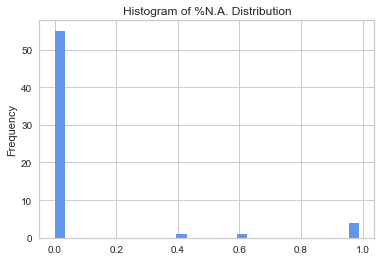

In [50]:
# Inspecting % of missing values
r=poverty_data.isnull().sum()/poverty_data.shape[0]
r.plot.hist(bins=30, color=colours)
plt.title("Histogram of %N.A. Distribution",fontdict={'fontsize': 12,'fontweight': "medium"})

*Histogram of %N.A. Distribution:*<br> 
Most features contain 0% NANs, while few contain 40% - 60% NaNs. Some contain almost 100% of missing values. We shall investigate whether we replace or drop them:

In [51]:
# Printing the percentage of missing values per column
def percent_missing(dataframe):
    # Summing the number of missing values per column and then dividing by the total
    sumMissing = dataframe.isnull().values.sum(axis=0)
    pctMissing = sumMissing / dataframe.shape[0]
    
    if sumMissing.sum() == 0:
        print('No missing values')
    else:
        # Looping through and printing out each columns missing value percentage
        print('Percent Missing Values:', '\n')
        for idx, col in enumerate(dataframe.columns):
            if sumMissing[idx] > 0:
                print('{0}: {1:.2f}%'.format(col, pctMissing[idx] * 100))
                
percent_missing(poverty_data)

Percent Missing Values: 

education_level: 1.83%
share_hh_income_provided: 2.37%
bank_interest_rate: 97.57%
mm_interest_rate: 98.83%
mfi_interest_rate: 98.58%
other_fsp_interest_rate: 98.05%
testflag: 60.00%
poverty_probability: 40.00%


We gather that the overall amount of missing values is rather low, however the percent of NaNs is exteremly high for 4 variables:
1. bank_interest_rate
2. mm_interest_rate
3. mfi_interest_rate
4. other_fsp_interest_rate

As they are not the most essential variables for our analysis, as age or gender might be for example, we decide to drop these.

The 40% missing values for poverty_probability may safely be disregarded, as there intentionally are no values provided for poverty_probability in the testset. The testflag variable simply flags whatever data belongs to the testset, thus it is missing from 60% of the data, which is the training data.

In [52]:
# Removing columns with high NaN
columns_with_high_NaN = ['bank_interest_rate', 'mfi_interest_rate', 'mm_interest_rate', 'other_fsp_interest_rate']
poverty_data.drop(columns_with_high_NaN, axis=1, inplace=True)

In [53]:
# Rerunning percent of missing values             
percent_missing(poverty_data)

Percent Missing Values: 

education_level: 1.83%
share_hh_income_provided: 2.37%
testflag: 60.00%
poverty_probability: 40.00%


We now only have low amounts of missing values in education_level and share_hh_income_provided and we will fill these with the mean.

__Taking a closer look at the two variables still containing missing values__
- education_level - Highest level of education (0=no education, 1=primary education, 2=secondary education, 3=higher education)
- share_hh_income_provided - Share of household income provided

In [54]:
# Filling empty rows with mean
poverty_data['education_level'].fillna(np.mean(poverty_data['education_level']), inplace = True)
poverty_data['share_hh_income_provided'].fillna(np.mean(poverty_data['share_hh_income_provided']), inplace = True)
percent_missing(poverty_data)

Percent Missing Values: 

testflag: 60.00%
poverty_probability: 40.00%


We no longer have missing values.<br>
<br>
**Outlier Analysis** <br>
As we could see missing values (NaN) in our snapshot above, we shall inspect Data quality

In [55]:
# Querying numeric features to know which features to check for outliers 
poverty_data.select_dtypes(include=np.number).columns.tolist()

['row_id',
 'age',
 'education_level',
 'share_hh_income_provided',
 'num_times_borrowed_last_year',
 'borrowing_recency',
 'num_shocks_last_year',
 'avg_shock_strength_last_year',
 'phone_technology',
 'phone_ownership',
 'num_formal_institutions_last_year',
 'num_informal_institutions_last_year',
 'num_financial_activities_last_year',
 'testflag',
 'poverty_probability']

In [56]:
# Setting up generic boxplot function to check numeric features for outliers
def boxplot(X):
    plt.figure(figsize = (15, 2))
    sns.boxplot(X)
    return sns.boxplot(X,color='cornflowerblue')

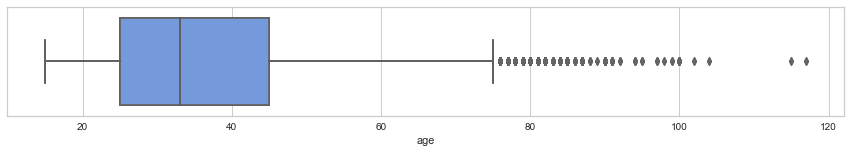

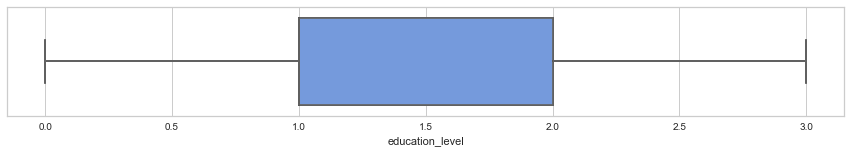

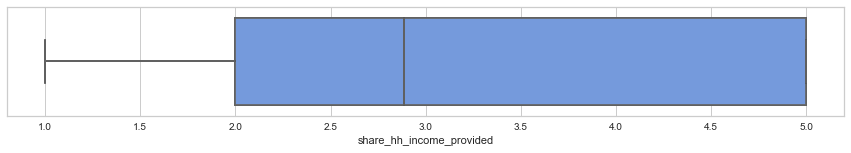

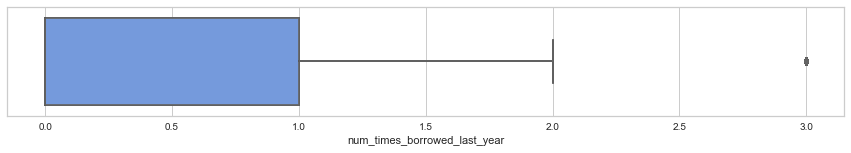

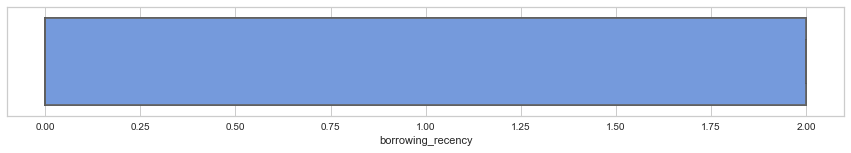

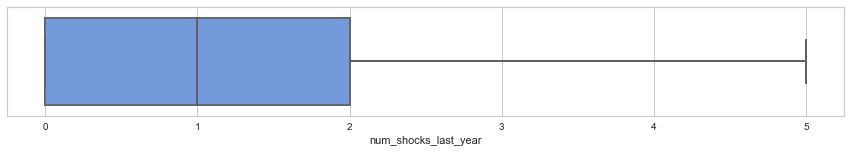

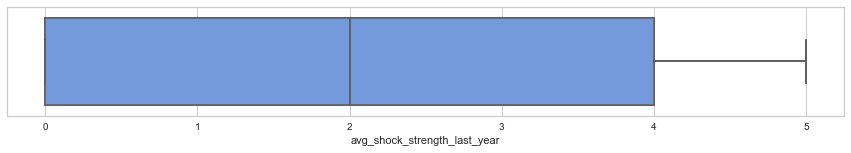

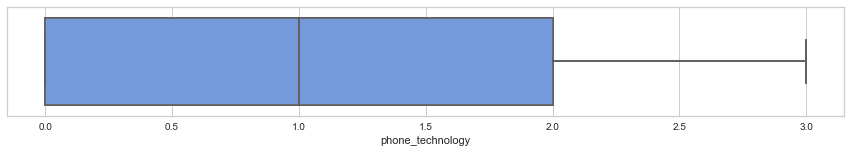

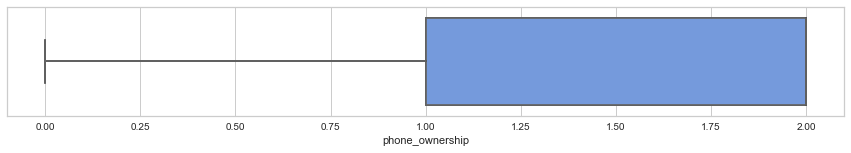

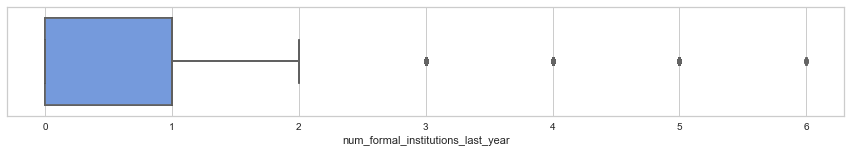

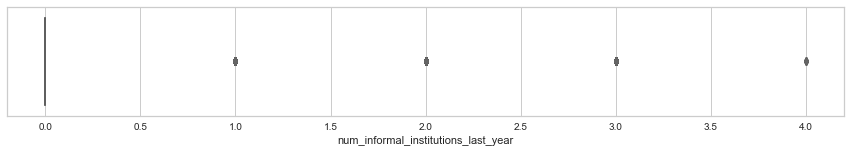

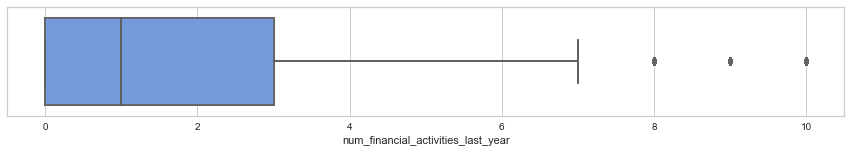

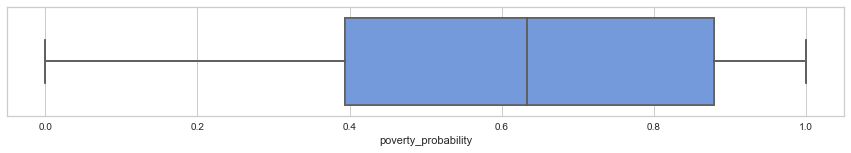

In [57]:
# Applying boxplot funtion to each numeric feature
boxplot(poverty_data['age'])
boxplot(poverty_data['education_level'])
boxplot(poverty_data['share_hh_income_provided'])
boxplot(poverty_data['num_times_borrowed_last_year'])
boxplot(poverty_data['borrowing_recency'])
boxplot(poverty_data['num_shocks_last_year'])
boxplot(poverty_data['avg_shock_strength_last_year'])
boxplot(poverty_data['phone_technology'])
boxplot(poverty_data['phone_ownership'])
boxplot(poverty_data['num_formal_institutions_last_year'])
boxplot(poverty_data['num_informal_institutions_last_year'])
boxplot(poverty_data['num_financial_activities_last_year'])
boxplot(poverty_data['poverty_probability'])

Looking at the boxplots above, we can see that the only extreme outliers are found within the age variable.
Though other outliers exist, e.g. for number of insititutions visited last year, the numbers do not seem unnatural. 
For age however, while most individuals are between 30-45 years old, however the outlier individuals are 3 times as old. 
We shall investigate for reasonability.

In [58]:
# Looking at outliers in poverty train data
poverty_data[poverty_data['age'] > 100]

,row_id,country,is_urban,age,female,married,religion,relationship_to_hh_head,education_level,literacy,can_add,can_divide,can_calc_percents,can_calc_compounding,employed_last_year,employment_category_last_year,employment_type_last_year,share_hh_income_provided,income_ag_livestock_last_year,income_friends_family_last_year,income_government_last_year,income_own_business_last_year,income_private_sector_last_year,income_public_sector_last_year,num_times_borrowed_last_year,borrowing_recency,formal_savings,informal_savings,cash_property_savings,has_insurance,has_investment,num_shocks_last_year,avg_shock_strength_last_year,borrowed_for_emergency_last_year,borrowed_for_daily_expenses_last_year,borrowed_for_home_or_biz_last_year,phone_technology,can_call,can_text,can_use_internet,can_make_transaction,phone_ownership,advanced_phone_use,reg_bank_acct,reg_mm_acct,reg_formal_nbfi_account,financially_included,active_bank_user,active_mm_user,active_formal_nbfi_user,active_informal_nbfi_user,nonreg_active_mm_user,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,testflag,poverty_probability
8236,8236,F,True,115.00,True,True,Q,Father/Mother,1.00,False,False,False,False,False,False,unemployed,not_working,3.00,False,True,False,False,False,False,0,0,False,False,False,False,False,0,0.00,False,True,False,0,True,True,False,False,1,False,False,False,False,False,False,False,False,False,False,1,0,0,NaN,0.63
9724,9724,F,True,104.00,False,True,Q,Head,1.00,False,True,True,False,True,False,retired_or_disabled,not_working,2.00,True,True,True,False,False,False,0,0,True,False,False,False,False,0,0.00,False,False,False,1,True,False,False,False,2,True,True,False,False,True,True,False,False,False,False,1,0,1,NaN,0.32
2056,2056,F,True,102.00,False,True,Q,Head,3.00,True,True,True,True,True,True,employed,salaried,4.00,True,True,True,False,False,True,0,0,False,False,False,False,False,1,4.00,False,False,False,3,False,True,False,True,2,True,True,False,False,True,True,False,False,False,False,1,0,4,1.00,NaN
4377,4377,F,False,117.00,True,True,X,Head,0.00,False,False,False,False,False,False,retired_or_disabled,not_working,1.00,True,True,False,False,False,False,0,0,False,False,False,False,False,2,1.00,False,False,False,0,True,False,False,False,1,False,False,False,False,False,False,False,False,False,False,0,0,0,1.00,NaN


Individuals with age above 104 will be dropped, given this age seems rather unrealistic.

In [59]:
# Dropping data for extreme outliers 
poverty_data.drop(data.index[[8236]], inplace = True)
poverty_data.drop(data.index[[4377]], inplace = True)

# Checking that only two outliers (9724 and 2056) are left
poverty_data[poverty_data['age'] > 100]

,row_id,country,is_urban,age,female,married,religion,relationship_to_hh_head,education_level,literacy,can_add,can_divide,can_calc_percents,can_calc_compounding,employed_last_year,employment_category_last_year,employment_type_last_year,share_hh_income_provided,income_ag_livestock_last_year,income_friends_family_last_year,income_government_last_year,income_own_business_last_year,income_private_sector_last_year,income_public_sector_last_year,num_times_borrowed_last_year,borrowing_recency,formal_savings,informal_savings,cash_property_savings,has_insurance,has_investment,num_shocks_last_year,avg_shock_strength_last_year,borrowed_for_emergency_last_year,borrowed_for_daily_expenses_last_year,borrowed_for_home_or_biz_last_year,phone_technology,can_call,can_text,can_use_internet,can_make_transaction,phone_ownership,advanced_phone_use,reg_bank_acct,reg_mm_acct,reg_formal_nbfi_account,financially_included,active_bank_user,active_mm_user,active_formal_nbfi_user,active_informal_nbfi_user,nonreg_active_mm_user,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,testflag,poverty_probability
9724,9724,F,True,104.00,False,True,Q,Head,1.00,False,True,True,False,True,False,retired_or_disabled,not_working,2.00,True,True,True,False,False,False,0,0,True,False,False,False,False,0,0.00,False,False,False,1,True,False,False,False,2,True,True,False,False,True,True,False,False,False,False,1,0,1,NaN,0.32
2056,2056,F,True,102.00,False,True,Q,Head,3.00,True,True,True,True,True,True,employed,salaried,4.00,True,True,True,False,False,True,0,0,False,False,False,False,False,1,4.00,False,False,False,3,False,True,False,True,2,True,True,False,False,True,True,False,False,False,False,1,0,4,1.00,NaN


<div class="alert alert-block alert-warning">
<b>(1) Section conclusion:</b>

*General Information*
- The dataset contains 21000 entries
- The dataset contains 59 features with another ('Testflag') created within this project. The features broadly cover capabilities (e.g. can_calc, can_add, literacy), access (e.g. can_make_transactions), demographics and financial history, amongst others. 
    
*Limitations and potential areas for Data Cleaning*
- With such a large number of features some are / will be redundant
- Interest rates contained many missing values, such that these variables had to be eliminated
- Age and share_hh_income_provided contained outliers tgahat had to be remedied<br>
- Many variables are of boolean type and must be transformed<br>
</div>


</div>

# 2. Exploratory Data Analysis

## 2.1. Generic Inspection 
<a id="GenericInspection"></a>

**Correlation Matrix**<br>
Using a correlation matrix enables us to observe how variables interact with each other

<Figure size 1440x1152 with 0 Axes>

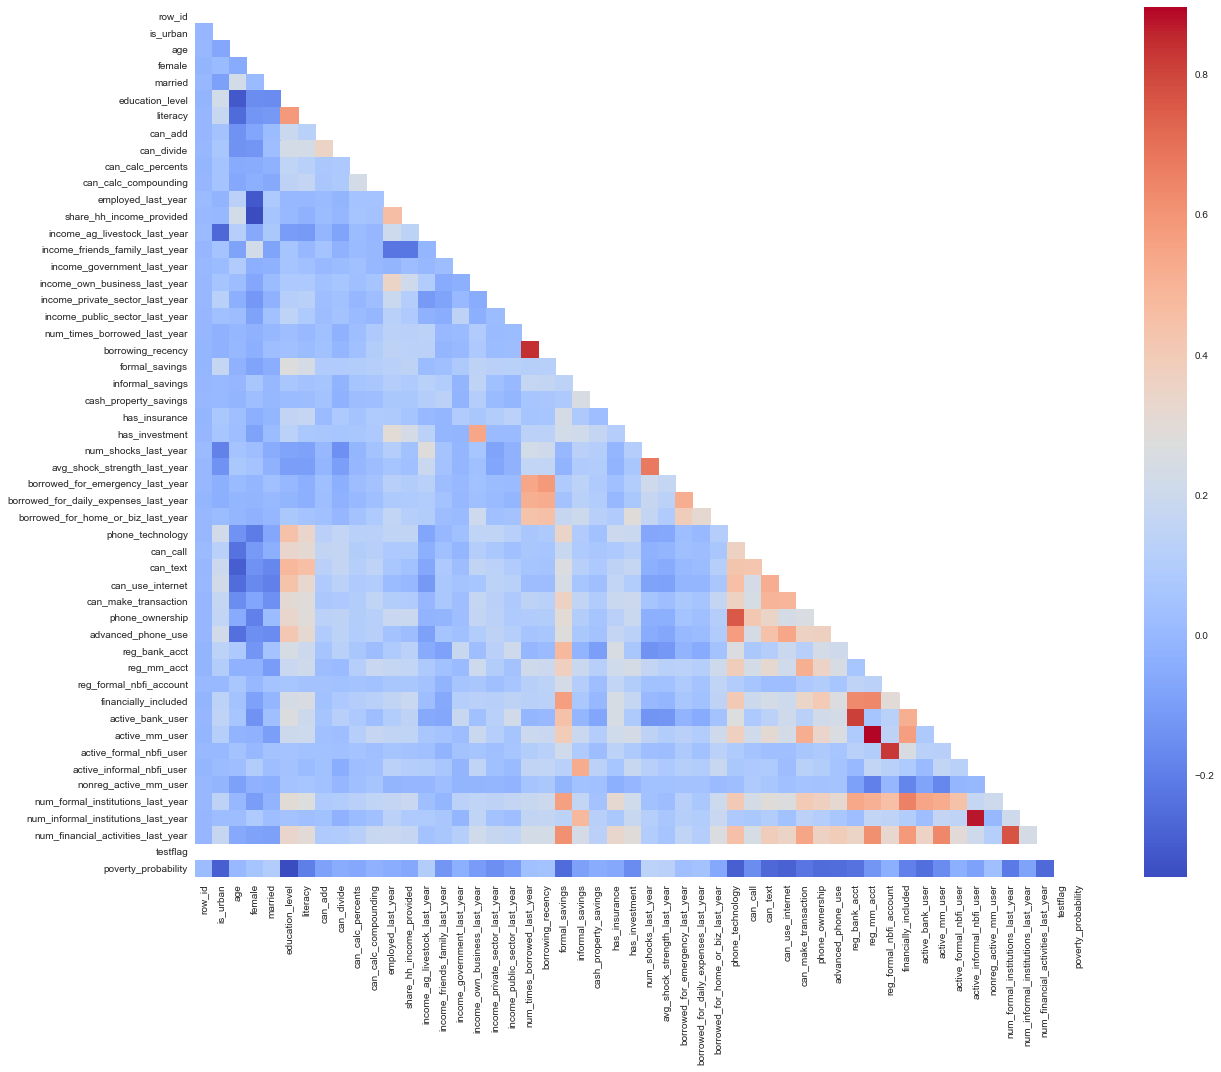

In [60]:
# Plotting correlation to detect strong correlations morea easily (strong colours)
plt.figure(figsize=(20,16)) 
matrix = np.triu(poverty_data.corr())
sns.heatmap(poverty_data.corr(),cmap = "coolwarm",mask=matrix)

*Graph Interpretation:*<br> 
The correlation matrix seems complex at first, however we must focus on dark red fields, as the negativie correlations are weak, only reaching up to -0.2.

We see a high correlation between:<br> 
- num_financial_activities_last_year and active_informal_nbfi user<br> 
- reg_mm_account and active_mm_user<br>
- borrowing_recency and num_times_borrowed_last_year<br>

As an overlap in the features was mentioned as limitation in the previous section, a high correlation is natural. We therefore decide not to eliminate any of the features just yet.

## 2.2. Inspection of Sample Demographics 
<a id="InspectionofSampleDemographics"></a>
<br>
__Familiarising ourselves with the sample__<br>
We will now look at the sample's key demographics

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Gender Distribution of Sample')

(-1.25, 1.25, -1.25, 1.25)

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Sample Between Urban and Non-urban Areas')

(-1.25, 1.25, -1.25, 1.25)

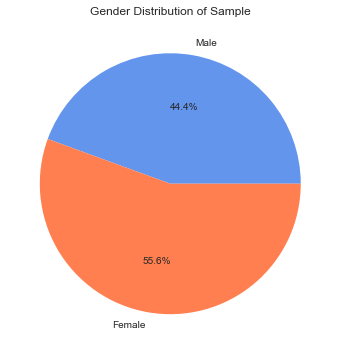

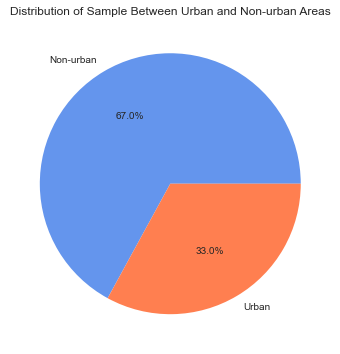

In [61]:
plt.figure(0)
# Creating first pie chart on gender distribution
poverty_data.groupby('female').size().plot(kind='pie', autopct='%1.1f%%', labels=['Male','Female'], title="",figsize = (6,6),colors=colours)
plt.title('Gender Distribution of Sample')
plt.axis('off')

plt.figure(1)
# Creating second pie chart on urban vs. rural areas
poverty_data.groupby('is_urban').size().plot(kind='pie', labels =['Non-urban','Urban'],autopct='%1.1f%%', title="",figsize = (6,6),colors=colours)
plt.title('Distribution of Sample Between Urban and Non-urban Areas')
plt.axis('off')

We see that the sample contains slighlty more female subjects than male. Further, 2/3 of the subjects live in rural areas. 

[Text(0, 0.5, 'Percent'),
 Text(0.5, 0, 'Age in yrs'),
 Text(0.5, 1.0, 'Age Distribution within Sample')]

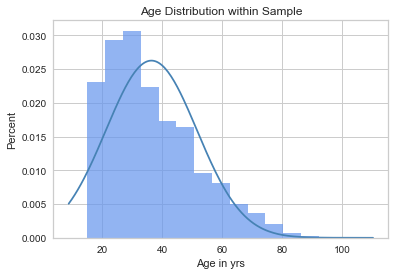

In [62]:
# Creating chart on age distribution of sample
ax = plt.figure()
sns.distplot(poverty_data['age'], bins=15, kde =False, fit=norm, color='cornflowerblue', fit_kws={"color":"steelblue"}, hist_kws=dict(alpha=0.7)).set(title='Age Distribution within Sample', xlabel='Age in yrs', ylabel='Percent')


We gather that most indivduals are between 15-50 yars old. The graph is right-skewed given few outliers, with very high age. Our dataset does not include minors.

## 2.3 Poverty Risk Assessment
<a id="PovertyRiskAssessment"></a>

We begin by analysing "poverty_probability" in relationship with a range of demographic metrics:

<Figure size 360x360 with 0 Axes>

Text(0.5, 1.0, 'Probability of Poverty split up by Gender')

<function matplotlib.pyplot.show(*args, **kw)>

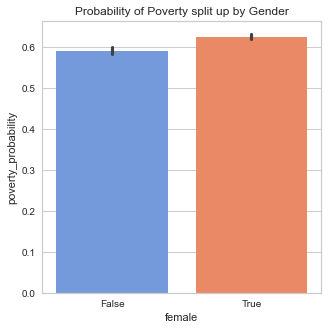

In [63]:
# Plotting poverty probability against gender
plt.figure(figsize = (5, 5))
plt.title('Probability of Poverty split up by Gender')
sns.barplot(data=poverty_data, x = 'female', y = 'poverty_probability',palette=colours)
plt.show

Both genders share more or less equal risk of poverty.

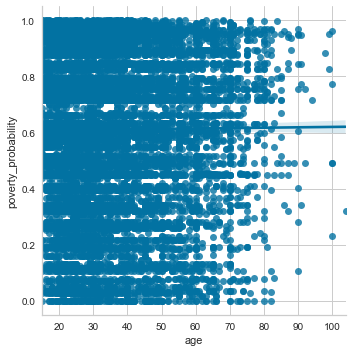

In [64]:
# Plotting poverty probability against age
sns.lmplot(data = poverty_data, x="age", y="poverty_probability", palette="coolwarm")

More individuals are younger, hence more datapoints exist, yet risk of poverty seems rather evenly dispersed across age.

<Figure size 360x360 with 0 Axes>

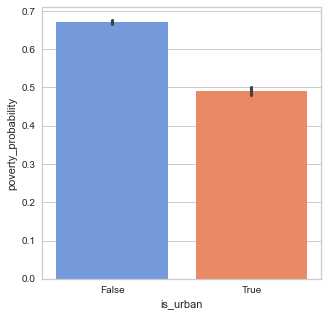

In [65]:
# Plotting poverty probability against urban areas
plt.figure(figsize = (5, 5))
sns.barplot(data=poverty_data, x = 'is_urban', y = 'poverty_probability',palette=colours)

Rural areas seem to be at greater risk of poverty.

<Figure size 720x360 with 0 Axes>

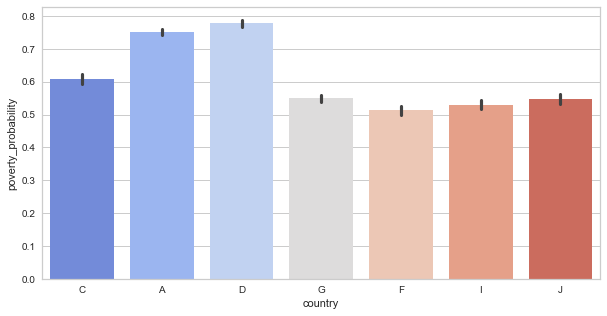

In [66]:
# Plotting poverty probability against country
plt.figure(figsize = (10, 5))
sns.barplot(data=poverty_data, x = 'country', y = 'poverty_probability',palette="coolwarm")

Countries A and D seem to share higher risk of poverty.

<Figure size 360x360 with 0 Axes>

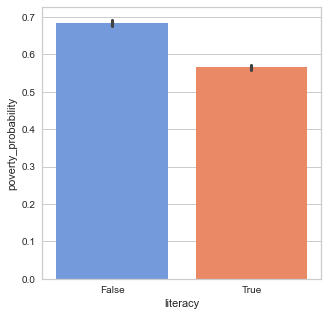

In [67]:
# Plotting poverty probability against literacy
plt.figure(figsize = (5, 5))
sns.barplot(data=poverty_data, x = 'literacy', y = 'poverty_probability',palette=colours)

Illiterates seem to be at greater risk of poverty.

<Figure size 360x360 with 0 Axes>

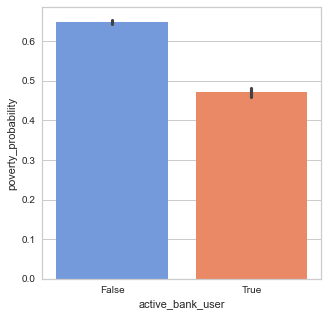

In [68]:
# Plotting poverty probability against whether or not someone is an active bank user
plt.figure(figsize = (5, 5))
sns.barplot(data=poverty_data, x = 'active_bank_user', y = 'poverty_probability',palette=colours)

Poverty risk is ca. 20% higher for inactive bank users.

<Figure size 360x360 with 0 Axes>

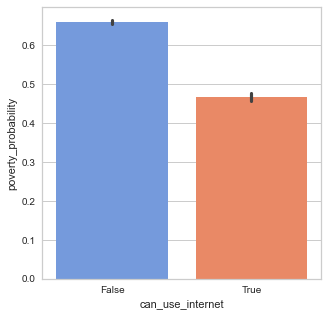

In [69]:
# Plotting poverty probability against capability of accessing / using internet
plt.figure(figsize = (5, 5))
sns.barplot(data=poverty_data, x = 'can_use_internet', y = 'poverty_probability',palette=colours)

Individuals that have no internet access are at higher risk of poverty.

<Figure size 360x360 with 0 Axes>

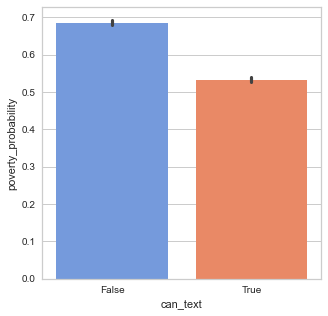

In [70]:
# Plotting poverty probability against ability to send text messages
plt.figure(figsize = (5, 5))
sns.barplot(data=poverty_data, x = 'can_text', y = 'poverty_probability',palette=colours)

Individuals unable to text are at greater risk of being poor.

<Figure size 360x360 with 0 Axes>

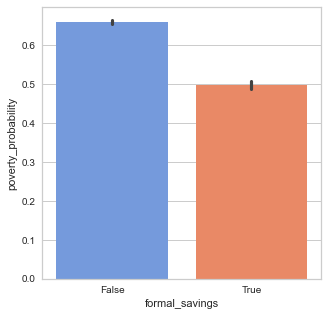

In [71]:
# Plotting poverty probability against whether or not individual has formal savings
plt.figure(figsize = (5, 5))
sns.barplot(data=poverty_data, x = 'formal_savings', y = 'poverty_probability',palette=colours)

Individuals without formal savings are at greater risk of being poor.

<Figure size 720x360 with 0 Axes>

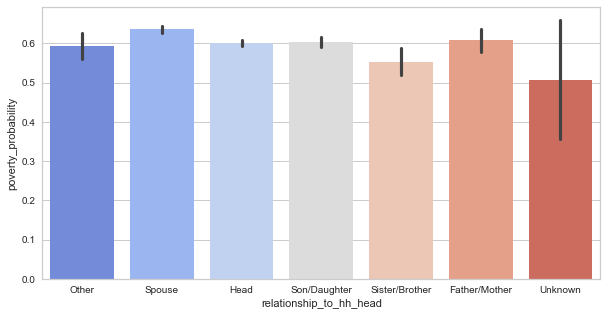

In [72]:
# Plotting poverty probability against relationship to household head
plt.figure(figsize = (10,5))
sns.barplot(data=poverty_data, x = 'relationship_to_hh_head', y = 'poverty_probability',palette="coolwarm")

Despite being rather equal, individuals whose spouse is the household head are at highest risk of being poor.

0.611271074773774

<Figure size 360x360 with 0 Axes>

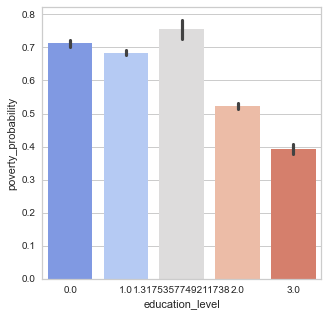

In [73]:
poverty_data.poverty_probability.mean()
plt.figure(figsize=(5, 5))
education_pov = sns.barplot(data = poverty_data, x = 'education_level', y = 'poverty_probability',palette="coolwarm")

The higher the education level, the lower the risk of poverty.

<div class="alert alert-block alert-warning">
<b>(2) Section conclusion:</b>

- Individuals in rural areas, lacking access to education, digital infrastructure and financial institutions seem to be at highest risk of poverty.
</div>


</div>

# 3. Feature Engineering

Due to the anonymous nature of the data, only very limited feature engineering can be done.
We will create 5 scores to better understand individuals and aggregate features:<br>
<br>
(1) Capability Score <br>
(2) Digital Access Score<br>
(3) Financial Stability Indicator<br>
(4) Savings Score<br>
(5) Borrowings Score<br>

### 3.1. Capabilty Score 
<a id="CapabilityScore"></a>

The **capability_score** will include the following variables: literacy, can_add, can_divide, can_calc_percents, can_calc_compounding

In [74]:
# Changing feature type to str and converting to binary variables (True to 1 and False to 0)
cap_mapper = {'False':0, 'True':1}
poverty_data['literacy'] = poverty_data['literacy'].astype(str)
poverty_data['literacy'].replace(cap_mapper, inplace = True)

poverty_data['can_add'] = poverty_data['can_add'].astype(str)
poverty_data['can_add'].replace(cap_mapper, inplace = True)

poverty_data['can_divide'] = poverty_data['can_divide'].astype(str)
poverty_data['can_divide'].replace(cap_mapper, inplace = True)

poverty_data['can_calc_percents'] = poverty_data['can_calc_percents'].astype(str)
poverty_data['can_calc_percents'].replace(cap_mapper, inplace=True)

poverty_data['can_calc_compounding'] = poverty_data['can_calc_compounding'].astype(str)
poverty_data['can_calc_compounding'].replace(cap_mapper, inplace=True)

# Adding up features to create capability score aggregating similar features
poverty_data['capability_score'] = poverty_data['literacy'] + poverty_data['can_add'] + poverty_data['can_divide'] + poverty_data['can_calc_percents'] + poverty_data['can_calc_compounding']


In [75]:
# Exploring new variable to understand scoring, mean and correlation with poverty_probability
poverty_data['capability_score'].head()
poverty_data['capability_score'].describe()
poverty_data['capability_score'].corr(poverty_data['poverty_probability'])

0    5
1    3
2    4
3    3
4    2
Name: capability_score, dtype: int64

count   20996.00
mean        3.19
std         1.23
min         0.00
25%         2.00
50%         3.00
75%         4.00
max         5.00
Name: capability_score, dtype: float64

-0.1482227700113394

In [76]:
# See if we can multiply our education level by capability_score to get overall intelligence level
poverty_data['overall_cognitive_ability'] = poverty_data['capability_score'] * poverty_data['education_level']
poverty_data['overall_cognitive_ability'].describe()
poverty_data['overall_cognitive_ability'].corr(poverty_data['poverty_probability'])

count   20996.00
mean        4.71
std         3.88
min         0.00
25%         2.00
50%         4.00
75%         8.00
max        15.00
Name: overall_cognitive_ability, dtype: float64

-0.3236626133843404

We see a slightly stronger negative correlation between poverty_probability and the score when multiplying it with education_level.<br> The lower overall_cognitive_ability, the higher the risk of poverty.

### 3.2. Digital Access Score
<a id="DigitalAccessScore"></a>

The **digital_access_score** will include the following variables: can_call, can_text, can_use_internet, can_make_transaction

In [77]:
# Changing feature type to str and converting to binary variables (True to 1 and False to 0)
dig_mapper = {'False':0, 'True':1}
poverty_data['can_call'] = poverty_data['can_call'].astype(str)
poverty_data['can_call'].replace(dig_mapper, inplace = True)

poverty_data['can_text'] = poverty_data['can_text'].astype(str)
poverty_data['can_text'].replace(dig_mapper, inplace = True)

poverty_data['can_use_internet'] = poverty_data['can_use_internet'].astype(str)
poverty_data['can_use_internet'].replace(dig_mapper, inplace = True)

poverty_data['can_make_transaction'] = poverty_data['can_make_transaction'].astype(str)
poverty_data['can_make_transaction'].replace(dig_mapper, inplace=True)

# Adding up features to create digital access score aggregating similar features
poverty_data['digital_access_score'] = poverty_data['can_call'] + poverty_data['can_text'] + poverty_data['can_use_internet'] + poverty_data['can_make_transaction']

In [78]:
# Exploring new variable to understand scoring, mean and correlation with poverty_probability
poverty_data['digital_access_score'].head()
poverty_data['digital_access_score'].describe()
poverty_data['digital_access_score'].corr(poverty_data['poverty_probability'])

0    2
1    1
2    1
3    1
4    3
Name: digital_access_score, dtype: int64

count   20996.00
mean        1.77
std         1.35
min         0.00
25%         1.00
50%         2.00
75%         3.00
max         4.00
Name: digital_access_score, dtype: float64

-0.3118983700705125

We see weak/moderate negative correlation between poverty_probability and the score when multiplying.<br> The lower the digital access, the higher the risk of poverty.

### 3.3. Savings Score
<a id="SavingsScore"></a>

The **savings_score** will include the following variables: formal_savings, informal_savings, cash_property_savings

In [79]:
# Changing feature type to str and converting to binary variables (True to 1 and False to 0)
sav_mapper = {'False':0, 'True':1}
poverty_data['formal_savings'] = poverty_data['formal_savings'].astype(str)
poverty_data['formal_savings'].replace(sav_mapper, inplace = True)

poverty_data['informal_savings'] = poverty_data['informal_savings'].astype(str)
poverty_data['informal_savings'].replace(sav_mapper, inplace = True)

poverty_data['cash_property_savings'] = poverty_data['cash_property_savings'].astype(str)
poverty_data['cash_property_savings'].replace(sav_mapper, inplace = True)

# Adding up features to create savings score aggregating similar features
poverty_data['savings_score'] = poverty_data['formal_savings'] + poverty_data['informal_savings'] + poverty_data['cash_property_savings']

In [80]:
# Exploring new variable to understand scoring, mean and correlation with poverty_probability
poverty_data['savings_score'].head()
poverty_data['savings_score'].describe()
poverty_data['savings_score'].corr(poverty_data['poverty_probability'])

0    0
1    0
2    0
3    0
4    1
Name: savings_score, dtype: int64

count   20996.00
mean        0.86
std         0.88
min         0.00
25%         0.00
50%         1.00
75%         1.00
max         3.00
Name: savings_score, dtype: float64

-0.196112614384702

We see a weak negative correlation between poverty_probability and the score when multiplying. <br>The fewer the savings, the higher the risk of poverty.

### 3.4. Borrowings Score
<a id="BorrowingsScore"></a>

The **borrowings_score** will include the following variables: borrowed_for_emergency_last_year, borrowed_for_daily_expenses_last_year, borrowed_for_home_or_biz_last_year   

In [81]:
# Changing feature type to str and converting to binary variables (True to 1 and False to 0)
bor_mapper = {'False':0, 'True':1}
poverty_data['borrowed_for_emergency_last_year'] = poverty_data['borrowed_for_emergency_last_year'].astype(str)
poverty_data['borrowed_for_emergency_last_year'].replace(bor_mapper, inplace = True)

poverty_data['borrowed_for_daily_expenses_last_year'] = poverty_data['borrowed_for_daily_expenses_last_year'].astype(str)
poverty_data['borrowed_for_daily_expenses_last_year'].replace(bor_mapper, inplace = True)

poverty_data['borrowed_for_home_or_biz_last_year'] = poverty_data['borrowed_for_home_or_biz_last_year'].astype(str)
poverty_data['borrowed_for_home_or_biz_last_year'].replace(bor_mapper, inplace = True)

# Adding up features to create borrowings score aggregating similar features
poverty_data['borrowings_score'] = poverty_data['borrowed_for_emergency_last_year'] + poverty_data['borrowed_for_daily_expenses_last_year'] + poverty_data['borrowed_for_home_or_biz_last_year']

In [82]:
# Exploring new variable to understand scoring, mean and correlation with poverty_probability
poverty_data['borrowings_score'].head()
poverty_data['borrowings_score'].describe()
poverty_data['borrowings_score'].corr(poverty_data['poverty_probability'])

0    0
1    0
2    0
3    0
4    0
Name: borrowings_score, dtype: int64

count   20996.00
mean        0.53
std         0.89
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         3.00
Name: borrowings_score, dtype: float64

0.011344449579154925

We encounter almost no correlation here.

<div class="alert alert-block alert-warning">
<b>(3) Section conclusion:</b>

The scores seem to a good way of aggregating overlapping / similar features, however they show no strong correlation with poverty_probability.<br>
</div>


</div>

# 4. Data Transformation & Pre-Processing
### 4.1. Numeric Feature Transformation 
<a id="NumFeatureEngineering"></a>

To achieve a more normal distribution of numeric features, some are transformed via logarithmic transformations.

In [83]:
# Dropping row_id as we do not need it in further analysis
poverty_data.drop('row_id', axis = 1, inplace = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd137dd3d90>,
      dtype=object)

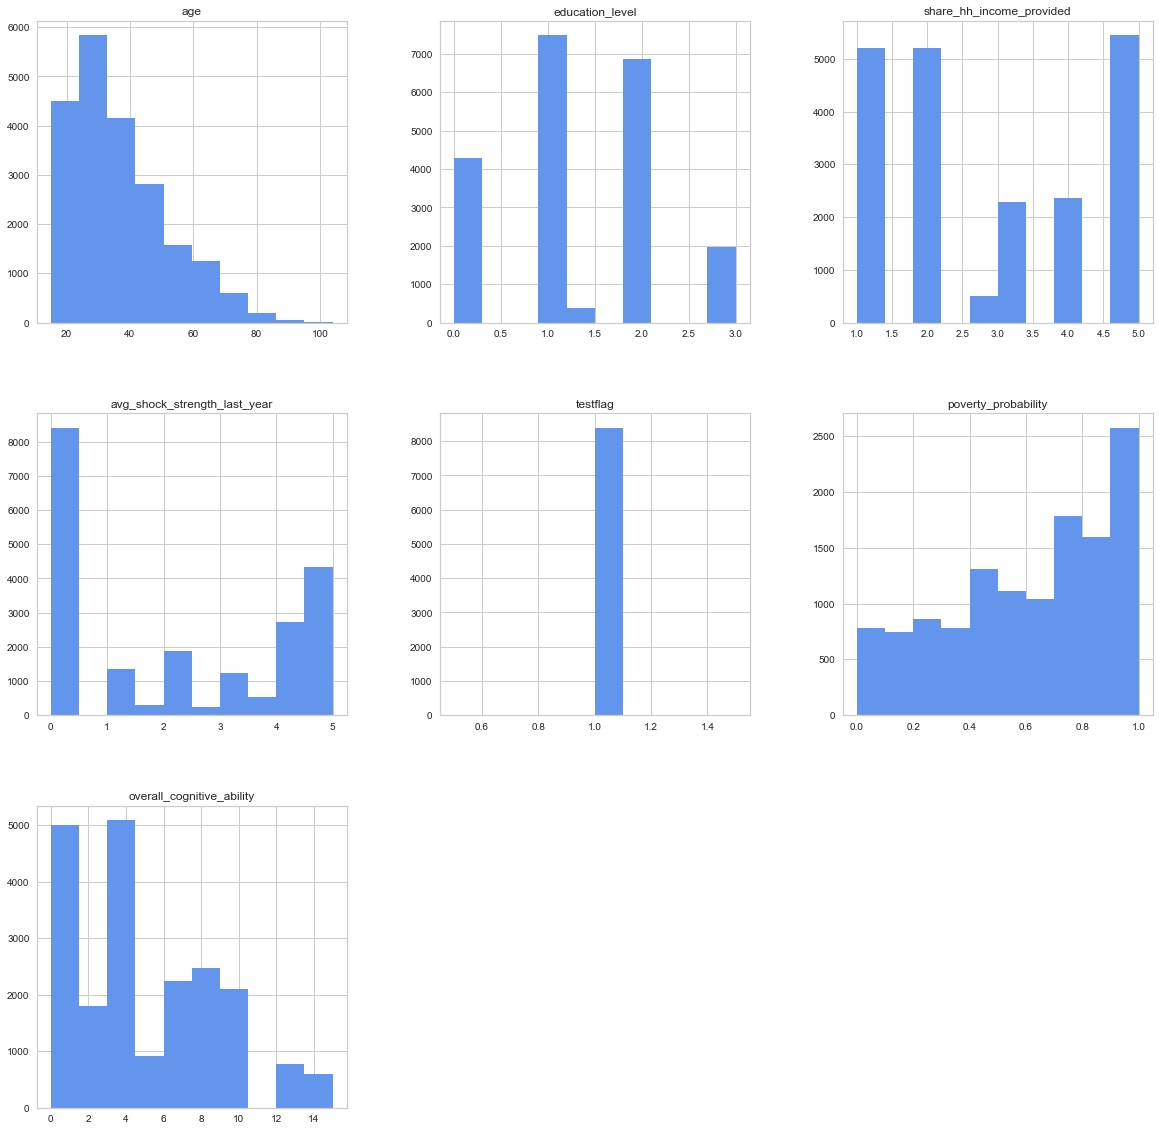

In [84]:
# Visualising numeric features to show lack of normal distribution
numeric_features = poverty_data.select_dtypes(include = ['float64', 'int64'])
numeric_features.hist(figsize = (20, 20),color='cornflowerblue')

*Graph Interpretation:*<br> 
The histograms visualises the strong right-skew within age. Therefore we normalise the feature.

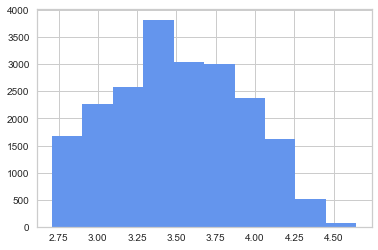

In [85]:
# Taking the log of age to normalise it as it had great outliers
np.log(poverty_data['age']).hist(color='cornflowerblue')

We see that age is now more normally distributed, and therefore contains non-integer values.

In [86]:
# Replacing age with the normalised age above
poverty_data['age'] = np.log(poverty_data['age'])

### 4.2. Feature Selection
<a id="FeatureSelection"></a>
All features created will be added to the dataframe: <br>

<br>
poverty_data["capability_score"]<br>
poverty_data["overall_cognitive_ability"]<br>
poverty_data["digital_access_score"]<br>
poverty_data["savings_scores"]<br>
poverty_data["borrowings_scores"]<br>

### 4.3. Final Checks
<a id="FinalChecks"></a>

**4.3.1 Inspect final dataframe**

In [87]:
# Transforming all booleans (True,False) into binary numeric values (1,0 respectively)
all_cols = poverty_data.columns
categorical_cols = []
numerical_cols = []

# create for loop to identify categorical and numerical columns
for col in all_cols:
    if poverty_data[col].dtype=='int64' or poverty_data[col].dtype=='float64': 
        numerical_cols.append(col)
    else:
        categorical_cols.append(col)

In [88]:
# Transforming all booleans (True,False) into binary numeric values (1,0 respectively)
poverty_data_new = pd.get_dummies(data=poverty_data, columns=categorical_cols)
poverty_data_new.head()

,age,education_level,literacy,can_add,can_divide,can_calc_percents,can_calc_compounding,share_hh_income_provided,num_times_borrowed_last_year,borrowing_recency,formal_savings,informal_savings,cash_property_savings,num_shocks_last_year,avg_shock_strength_last_year,borrowed_for_emergency_last_year,borrowed_for_daily_expenses_last_year,borrowed_for_home_or_biz_last_year,phone_technology,can_call,can_text,can_use_internet,can_make_transaction,phone_ownership,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,testflag,poverty_probability,capability_score,overall_cognitive_ability,digital_access_score,savings_score,borrowings_score,country_A,country_C,country_D,country_F,country_G,country_I,country_J,is_urban_False,is_urban_True,female_False,female_True,married_False,married_True,religion_N,religion_O,religion_P,...,relationship_to_hh_head_Spouse,relationship_to_hh_head_Unknown,employed_last_year_False,employed_last_year_True,employment_category_last_year_employed,employment_category_last_year_housewife_or_student,employment_category_last_year_other,employment_category_last_year_retired_or_disabled,employment_category_last_year_unemployed,employment_type_last_year_irregular_seasonal,employment_type_last_year_not_working,employment_type_last_year_other,employment_type_last_year_salaried,employment_type_last_year_self_employed,income_ag_livestock_last_year_False,income_ag_livestock_last_year_True,income_friends_family_last_year_False,income_friends_family_last_year_True,income_government_last_year_False,income_government_last_year_True,income_own_business_last_year_False,income_own_business_last_year_True,income_private_sector_last_year_False,income_private_sector_last_year_True,income_public_sector_last_year_False,income_public_sector_last_year_True,has_insurance_False,has_insurance_True,has_investment_False,has_investment_True,advanced_phone_use_False,advanced_phone_use_True,reg_bank_acct_False,reg_bank_acct_True,reg_mm_acct_False,reg_mm_acct_True,reg_formal_nbfi_account_False,reg_formal_nbfi_account_True,financially_included_False,financially_included_True,active_bank_user_False,active_bank_user_True,active_mm_user_False,active_mm_user_True,active_formal_nbfi_user_False,active_formal_nbfi_user_True,active_informal_nbfi_user_False,active_informal_nbfi_user_True,nonreg_active_mm_user_False,nonreg_active_mm_user_True
0,2.89,1.00,1,1,1,1,1,1.00,0,0,0,0,0,0,0.00,0,0,0,0,1,1,0,0,1,1,0,1,NaN,0.52,5,5.00,2,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0
1,3.40,1.00,1,1,1,0,0,2.89,0,0,0,0,0,0,0.00,0,0,0,1,1,0,0,0,2,1,0,0,NaN,0.98,3,3.00,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0
2,3.00,1.00,1,1,1,1,0,1.00,1,2,0,0,0,0,0.00,0,0,0,1,1,0,0,0,2,0,0,0,NaN,0.98,4,4.00,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,...,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
3,4.11,0.00,0,1,1,0,1,2.89,0,0,0,0,0,0,0.00,0,0,0,0,1,0,0,0,0,0,0,0,NaN,0.88,3,0.00,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
4,3.26,1.00,1,0,1,0,0,2.00,0,0,0,0,1,0,0.00,0,0,0,0,1,1,0,1,1,1,0,3,NaN,0.80,2,2.00,3,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,...,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0


**4.3.2 Re-checking missing values**

In [89]:
# Rerunning percent of missing values             
percent_missing(poverty_data_new)

Percent Missing Values: 

testflag: 60.00%
poverty_probability: 40.00%


**4.3.3 Re-assessing Multicollinearity**

In [90]:
# Checking multicollinearity
poverty_data_new.corr()

,age,education_level,literacy,can_add,can_divide,can_calc_percents,can_calc_compounding,share_hh_income_provided,num_times_borrowed_last_year,borrowing_recency,formal_savings,informal_savings,cash_property_savings,num_shocks_last_year,avg_shock_strength_last_year,borrowed_for_emergency_last_year,borrowed_for_daily_expenses_last_year,borrowed_for_home_or_biz_last_year,phone_technology,can_call,can_text,can_use_internet,can_make_transaction,phone_ownership,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,testflag,poverty_probability,capability_score,overall_cognitive_ability,digital_access_score,savings_score,borrowings_score,country_A,country_C,country_D,country_F,country_G,country_I,country_J,is_urban_False,is_urban_True,female_False,female_True,married_False,married_True,religion_N,religion_O,religion_P,...,relationship_to_hh_head_Spouse,relationship_to_hh_head_Unknown,employed_last_year_False,employed_last_year_True,employment_category_last_year_employed,employment_category_last_year_housewife_or_student,employment_category_last_year_other,employment_category_last_year_retired_or_disabled,employment_category_last_year_unemployed,employment_type_last_year_irregular_seasonal,employment_type_last_year_not_working,employment_type_last_year_other,employment_type_last_year_salaried,employment_type_last_year_self_employed,income_ag_livestock_last_year_False,income_ag_livestock_last_year_True,income_friends_family_last_year_False,income_friends_family_last_year_True,income_government_last_year_False,income_government_last_year_True,income_own_business_last_year_False,income_own_business_last_year_True,income_private_sector_last_year_False,income_private_sector_last_year_True,income_public_sector_last_year_False,income_public_sector_last_year_True,has_insurance_False,has_insurance_True,has_investment_False,has_investment_True,advanced_phone_use_False,advanced_phone_use_True,reg_bank_acct_False,reg_bank_acct_True,reg_mm_acct_False,reg_mm_acct_True,reg_formal_nbfi_account_False,reg_formal_nbfi_account_True,financially_included_False,financially_included_True,active_bank_user_False,active_bank_user_True,active_mm_user_False,active_mm_user_True,active_formal_nbfi_user_False,active_formal_nbfi_user_True,active_informal_nbfi_user_False,active_informal_nbfi_user_True,nonreg_active_mm_user_False,nonreg_active_mm_user_True
age,1.00,-0.30,-0.25,-0.12,-0.12,-0.04,-0.05,0.27,0.02,0.02,0.01,0.01,-0.00,0.04,0.07,0.03,0.00,0.01,-0.10,-0.21,-0.28,-0.25,-0.13,-0.01,0.03,0.04,-0.03,NaN,0.00,-0.20,-0.28,-0.30,0.01,0.02,0.01,0.05,-0.01,-0.03,-0.03,0.01,0.01,0.06,-0.06,0.04,-0.04,-0.30,0.30,-0.00,0.01,0.05,...,0.01,-0.01,-0.18,0.18,0.18,-0.26,0.01,0.27,-0.11,0.09,-0.19,0.01,0.01,0.11,-0.12,0.12,0.10,-0.10,-0.08,0.08,-0.05,0.05,0.02,-0.02,-0.04,0.04,-0.04,0.04,-0.06,0.06,0.24,-0.24,-0.11,0.11,-0.00,0.00,-0.08,0.08,-0.08,0.08,-0.08,0.08,-0.01,0.01,-0.06,0.06,-0.05,0.05,0.10,-0.10
education_level,-0.30,1.00,0.58,0.19,0.23,0.15,0.14,0.01,0.03,0.04,0.28,0.07,0.02,-0.07,-0.09,0.00,-0.01,0.07,0.44,0.34,0.48,0.44,0.31,0.33,0.30,0.05,0.34,NaN,-0.34,0.47,0.91,0.53,0.18,0.02,0.03,-0.08,-0.07,0.10,0.12,-0.04,-0.05,-0.23,0.23,0.15,-0.15,0.16,-0.16,-0.04,-0.02,-0.07,...,-0.15,0.01,-0.00,0.00,0.00,0.02,-0.03,-0.10,0.06,-0.17,0.01,-0.03,0.18,0.01,0.10,-0.10,-0.05,0.05,-0.05,0.05,-0.08,0.08,-0.12,0.12,-0.15,0.15,-0.16,0.16,-0.13,0.13,-0.42,0.42,-0.25,0.25,-0.19,0.19,-0.06,0.06,-0.24,0.24,-0.27,0.27,-0.20,0.20,-0.05,0.05,-0.04,0.04,-0.05,0.05
literacy,-0.25,0.58,1.00,0.13,0.23,0.12,0.17,-0.02,0.01,0.02,0.24,0.04,0.02,-0.09,-0.09,-0.03,-0.03,0.05,0.34,0.31,0.45,0.33,0.29,0.29,0.27,0.03,0.30,NaN,-0.20,0.62,0.64,0.47,0.16,-0.01,0.00,0.03,0.16,-0.12,0.10,-0.00,-0.17,-0.18,0.18,0.12,-0.12,0.11,-0.11,-0.02,-0.01,0.03,...,-0.11,0.01,-0.00,0.00,0.00,0.03,-0.02,-0.10,0.03,-0.16,0.01,-0.02,0.16,0.01,0.11,-0.11,-0.00,0.00,-0.04,0.04,-0.08,0.08,-0.12,0.12,-0.09,0.09,-0.17,0.17,-0.08,0.08,-0.32,0.32,-0.20,0.20,-0.21,0.21,-0.05,0.

*Output Interpretation:*<br> 
Given our transformation of categorical features to dummies, we now have much more variables. We focus our inspection on the newly created scores.

Education_level seems highly correlated with the overall_cognitive_ability. Its removal was considered, however it does prove vital in later feature importance measurements. Therefore education_level remains. The same applies to can_use_internet and the savings features included in the savings score.

Other variables that make up the scores are dropped.

Interestingly digital access score is positively associated with education level.

In [91]:
# Dropping features that are now compounded in overall_cognitive_ability
poverty_data_new.drop(['literacy', 'can_add','can_divide','can_calc_percents','can_calc_compounding','can_call','can_text','can_make_transaction','borrowed_for_emergency_last_year','borrowed_for_daily_expenses_last_year','borrowed_for_home_or_biz_last_year'], axis=1, inplace=True)
poverty_data_new.head()


,age,education_level,share_hh_income_provided,num_times_borrowed_last_year,borrowing_recency,formal_savings,informal_savings,cash_property_savings,num_shocks_last_year,avg_shock_strength_last_year,phone_technology,can_use_internet,phone_ownership,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,testflag,poverty_probability,capability_score,overall_cognitive_ability,digital_access_score,savings_score,borrowings_score,country_A,country_C,country_D,country_F,country_G,country_I,country_J,is_urban_False,is_urban_True,female_False,female_True,married_False,married_True,religion_N,religion_O,religion_P,religion_Q,religion_X,relationship_to_hh_head_Father/Mother,relationship_to_hh_head_Head,relationship_to_hh_head_Other,relationship_to_hh_head_Sister/Brother,relationship_to_hh_head_Son/Daughter,relationship_to_hh_head_Spouse,relationship_to_hh_head_Unknown,employed_last_year_False,employed_last_year_True,employment_category_last_year_employed,employment_category_last_year_housewife_or_student,employment_category_last_year_other,employment_category_last_year_retired_or_disabled,employment_category_last_year_unemployed,employment_type_last_year_irregular_seasonal,employment_type_last_year_not_working,employment_type_last_year_other,employment_type_last_year_salaried,employment_type_last_year_self_employed,income_ag_livestock_last_year_False,income_ag_livestock_last_year_True,income_friends_family_last_year_False,income_friends_family_last_year_True,income_government_last_year_False,income_government_last_year_True,income_own_business_last_year_False,income_own_business_last_year_True,income_private_sector_last_year_False,income_private_sector_last_year_True,income_public_sector_last_year_False,income_public_sector_last_year_True,has_insurance_False,has_insurance_True,has_investment_False,has_investment_True,advanced_phone_use_False,advanced_phone_use_True,reg_bank_acct_False,reg_bank_acct_True,reg_mm_acct_False,reg_mm_acct_True,reg_formal_nbfi_account_False,reg_formal_nbfi_account_True,financially_included_False,financially_included_True,active_bank_user_False,active_bank_user_True,active_mm_user_False,active_mm_user_True,active_formal_nbfi_user_False,active_formal_nbfi_user_True,active_informal_nbfi_user_False,active_informal_nbfi_user_True,nonreg_active_mm_user_False,nonreg_active_mm_user_True
0,2.89,1.00,1.00,0,0,0,0,0,0,0.00,0,0,1,1,0,1,NaN,0.52,5,5.00,2,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0
1,3.40,1.00,2.89,0,0,0,0,0,0,0.00,1,0,2,1,0,0,NaN,0.98,3,3.00,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0
2,3.00,1.00,1.00,1,2,0,0,0,0,0.00,1,0,2,0,0,0,NaN,0.98,4,4.00,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
3,4.11,0.00,2.89,0,0,0,0,0,0,0.00,0,0,0,0,0,0,NaN,0.88,3,0.00,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
4,3.26,1.00,2.00,0,0,0,0,1,0,0.00,0,0,1,1,0,3,NaN,0.80,2,2.00,3,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0


<div class="alert alert-block alert-warning">
<b>(4) Section conclusion:</b>
Feature scaling and dropping of correlated variables was done to improve data cleanliness.
</div>



# 5. Model Implementation, Evaluation & Improvement

Having finalised the dataframe to be used including all relevant features, we now split the dataset into a training
and testset.<br>
Subsequently, we drop the testflag and poverty_probaility from the testset.<br>
We then define labels, to be predicted, as well as the features.

In [93]:
# Splitting train and test based on testflag to start training models without test data
train_data = poverty_data_new[poverty_data_new['testflag'] != 1]
test_data = poverty_data_new[poverty_data_new['testflag'] == 1]

# Dropping target from test set as it does not contain poverty probabilities
test_data.drop('poverty_probability', axis=1, inplace=True)

# Dropping testflag from data as data is now split and flag is no longer needed
test_data.drop('testflag', axis=1, inplace=True)
train_data.drop('testflag', axis=1, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [94]:
# Storing labeling data in separate df
labels = train_data['poverty_probability']

# Specifying features and dropping poverty_probability from it as this is what we want to predict
features = train_data.drop('poverty_probability', axis = 1)

# Splitting training data into train and test set for validation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = .2, random_state = 45)

## 5.1. Model Implementation & Initial Evaluation Score 
<a id="ModelImplementation"></a>
The following models will be implemented and compared in their ability to predict poverty_probability:<br>
<br>
5.1.1. Linear Regression<br>
5.1.2. LightGBM<br>
5.1.3. Gradient Boost<br>
5.1.4. XG Boost<br>
5.1.5 Random Forest<br>

They are compared along R-squared score, mean squared error, residual mean squared error, mean absolute error.


**5.1.1 Linear Regression**

In [95]:
startTime = time.time()  # Getting training time

# Running regression on X_test
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
totalTime = time.time() - startTime
predictions = lin_reg.predict(X_test)

# Calculating error metrics to make models comparable
r2 = lin_reg.score(X_test, y_test) # a high R squared is desired, as this means much of the variation is accounted for
rmse = np.sqrt(mean_squared_error(y_test, predictions)) # a low RMSE is desired, as it measures the differences between values predicted by the model and the values observed
mae = mean_absolute_error(y_test, predictions) # a low MAE is desired, as it measures the average magnitude of the errors in the set of predictions

score_results = pd.Series([r2, mae, rmse, totalTime], index=['R squared', 'MAE', 'RMSE','TrainingTime(sec)'])
score_results

LinearRegression()

R squared           0.37
MAE                 0.19
RMSE                0.23
TrainingTime(sec)   0.03
dtype: float64

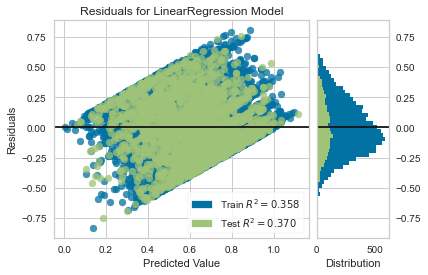

In [96]:
# Creating visualizer to show how well model predicts poverty porability
# R squared accounts for how much variation in the model is accounted for
viz = residuals_plot(lin_reg, X_train, y_train, X_test, y_test)

FeatureImportances(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1410ee8e0>,
                   estimator=LinearRegression(), topn=10)

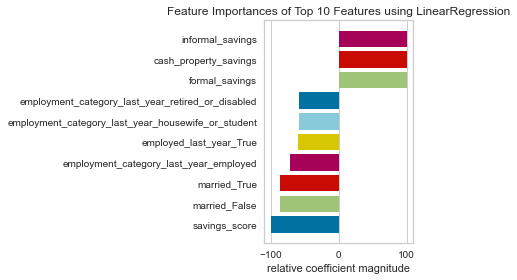

In [97]:
# Displaying most important features in predicting poverty_probability
viz = FeatureImportances(lin_reg,topn=10)
viz.fit(X_train, y_train)
viz.show()

**5.1.2 LightGBM**

In [98]:
startTime = time.time()  # Getting training time

#Converting the data into proper LGB Dataset Format
lgb_model= lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=1000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


# Creating and training LightGB model
lgb_model.fit(X_train, y_train,)
totalTime = time.time() - startTime

# Predicting model on X_test
y_pred=lgb_model.predict(X_test)

# Calculating error metrics to make models comparable
r2 = lgb_model.score(X_test, y_test) # a high R squared is desired, as this means much of the variation is accounted for
mse = mean_squared_error(y_pred,y_test) # a low MSE is desired, as it measures the average squared difference between the predicted values of the model and the actual values 
rmse = np.sqrt(mse) # a low RMSE is desired, as it measures the differences between values predicted by the model and the values observed
mae = mean_absolute_error(y_test, predictions) # a low MAE is desired, as it measures the average magnitude of the errors in the set of predictions

score_results = pd.Series([r2, mae, rmse, mse,totalTime], index=['R squared', 'MAE', 'RMSE','MSE','TrainingTime(sec)'])
score_results

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2319, feature_fraction_seed=9,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=1000, num_leaves=5,
              objective='regression')

R squared           0.45
MAE                 0.19
RMSE                0.22
MSE                 0.05
TrainingTime(sec)   0.91
dtype: float64

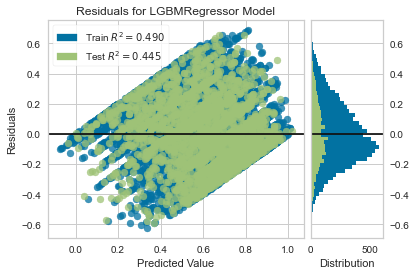

In [99]:
# Creating visualizer to show how well model predicts poverty porability
# R squared accounts for how much variation in the model is accounted for
viz = residuals_plot(lgb_model, X_train, y_train, X_test, y_test)

**5.1.3 Gradient Boost**

In [100]:
startTime = time.time()  # Getting training time

# Creating and training Gradient Boost model
gbt_model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=1)
  
gbt_model.fit(X_train, y_train)
totalTime = time.time() - startTime
predictions = gbt_model.predict(X_test)
        
# Calculating error metrics to make models comparable
r2 = gbt_model.score(X_test, y_test) # a high R squared is desired, as this means much of the variation is accounted for
rmse = np.sqrt(mean_squared_error(y_test, predictions)) # a low RMSE is desired, as it measures the differences between values predicted by the model and the values observed
mae = mean_absolute_error(y_test, predictions) # a low MAE is desired, as it measures the average magnitude of the errors in the set of predictions
            
score_results = pd.Series([r2, mae, rmse,totalTime], index=['R squared', 'MAE', 'RMSE','TrainingTime(sec)'])
score_results

GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000, random_state=1)

R squared            0.43
MAE                  0.18
RMSE                 0.22
TrainingTime(sec)   20.00
dtype: float64

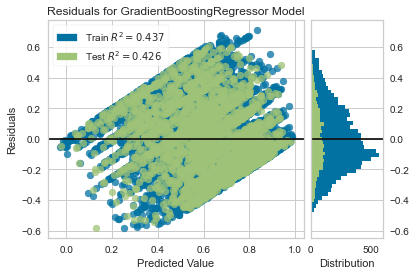

In [101]:
# Creating visualizer to show how well model predicts poverty porability
# R squared accounts for how much variation in the model is accounted for
viz = residuals_plot(gbt_model, X_train, y_train, X_test, y_test)

FeatureImportances(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd13c26e9a0>,
                   estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                       n_estimators=1000,
                                                       random_state=1),
                   topn=10)

<bound method Visualizer.show of FeatureImportances(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd13c26e9a0>,
                   estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                       n_estimators=1000,
                                                       random_state=1),
                   topn=10)>

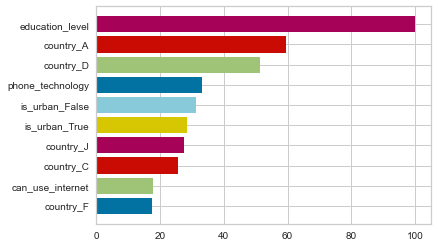

In [102]:
# Displaying most important features in predicting poverty_probability
viz = FeatureImportances(gbt_model,topn=10)
viz.fit(X_train, y_train)
viz.show                            

**5.1.4 XGBoost**

In [104]:
startTime = time.time()  # Getting training time

# Creating and training XGBoost model
xgb_model= xgb.XGBRegressor(n_estimators=100,reg_lambda=1,gamma=0,max_depth=3)
  
xgb_model.fit(X_train, y_train)
totalTime = time.time() - startTime
predictions = xgb_model.predict(X_test)
        
# Calculating error metrics to make models comparable
r2 = xgb_model.score(X_test, y_test) # a high R squared is desired, as this means much of the variation is accounted for
rmse = np.sqrt(mean_squared_error(y_test, predictions)) # a low RMSE is desired, as it measures the differences between values predicted by the model and the values observed
mae = mean_absolute_error(y_test, predictions) # a low MAE is desired, as it measures the average magnitude of the errors in the set of predictions
            
score_results = pd.Series([r2, mae, rmse,totalTime], index=['R squared', 'MAE', 'RMSE','TrainingTime(sec)'])
score_results

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

R squared           0.44
MAE                 0.18
RMSE                0.22
TrainingTime(sec)   0.60
dtype: float64

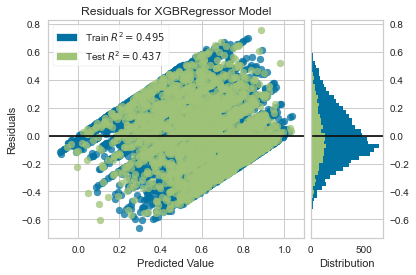

In [105]:
# Creating visualizer to show how well model predicts poverty porability
# R squared accounts for how much variation in the model is accounted for
viz = residuals_plot(xgb_model, X_train, y_train, X_test, y_test)

FeatureImportances(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd14098e160>,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=3,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=8,
                                          num_parallel_tree=1, random_state=0,
                                          reg_alpha=0, reg

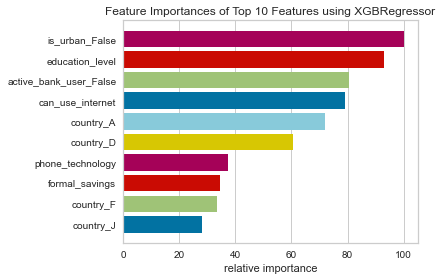

In [106]:
# Displaying most important features in predicting poverty_probability
viz = FeatureImportances(xgb_model,topn=10)
viz.fit(X_train, y_train)
viz.show()

**5.1.5 Random Forest**

In [107]:
startTime = time.time()  # Getting training time

random_f = RandomForestRegressor(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=2)
        
# Creating and training Random Forest
random_f.fit(X_train, y_train)
totalTime = time.time() - startTime
predictions = random_f.predict(X_test)

# Calculating error metric to make models comparable
r2 = random_f.score(X_test, y_test) # a high R squared is desired, as this means much of the variation is accounted for
rmse = np.sqrt(mean_squared_error(y_test, predictions)) # a low RMSE is desired, as it measures the differences between values predicted by the model and the values observed
mae = mean_absolute_error(y_test, predictions) # a low MAE is desired, as it measures the average magnitude of the errors in the set of predictions

score_results = pd.Series([r2, mae, rmse,totalTime], index=['R squared', 'MAE', 'RMSE','TrainingTime(sec)'])
score_results

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=2)

R squared            0.42
MAE                  0.18
RMSE                 0.22
TrainingTime(sec)   17.97
dtype: float64

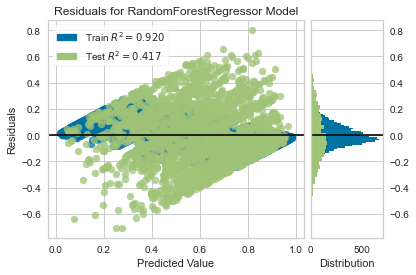

In [108]:
# Creating visualizer to show how well model predicts poverty porability
# R squared accounts for how much variation in the model is accounted for
viz = residuals_plot(random_f, X_train, y_train, X_test, y_test)

In [109]:
startTime = time.time()  # Getting training time

# Creating and training XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100,reg_lambda=1,gamma=0,max_depth=3)
xgb_model.fit(X_train, y_train)

totalTime = time.time() - startTime
predictions = xgb_model.predict(X_test)

# Calculating error metrics to make models comparable
r2 = xgb_model.score(X_test, y_test) # a high R squared is desired, as this means much of the variation is accounted for
mse = mean_squared_error(y_test, predictions) # a low MSE is desired, as it measures the average squared difference between the predicted values of the model and the actual values
rmse = np.sqrt(mean_squared_error(y_test, predictions)) # a low RMSE is desired, as it measures the differences between values predicted by the model and the values observed
mae = mean_absolute_error(y_test, predictions) # a low MAE is desired, as it measures the average magnitude of the errors in the set of predictions
            
score_results = pd.Series([r2, mae, rmse,totalTime], index=['R squared', 'MAE', 'RMSE','TrainingTime(sec)'])
score_results

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

R squared           0.44
MAE                 0.18
RMSE                0.22
TrainingTime(sec)   0.85
dtype: float64

FeatureImportances(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd13e6328e0>,
                   estimator=RandomForestRegressor(n_estimators=1000, n_jobs=-1,
                                                   random_state=2),
                   topn=10)

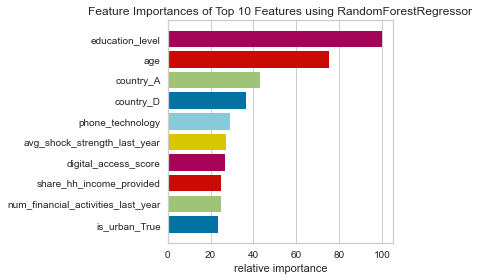

In [110]:
# Displaying most important features in predicting poverty_probability
viz = FeatureImportances(random_f,topn=10)
viz.fit(X_train, y_train)
viz.show()

Comparing the R-squared of the models, we see that the LightGBM and XGBoost perform best, achieving R-squared of 0.445 and 0.437 respectively.

Looking at feature importances across models, the capability_score, savings, education_level, age and countries A and D seem most important in predicting poverty. 

### 5.2. Improvement: Random Forest Hyperparameter Tuning
<a id="HyperParameterTuning"></a>

Next we try to optimise the RandomForestRegressor by tuning its hyperparameters.

In [111]:
# Looking at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(random_f.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}


**Random Search Cross Validation**<br>
Random Search sets up a grid of hyperparameter values and selects random combinations to train the model and score.<br> This allows you to explicitly control the number of parameter combinations that are attempted.

In [112]:
# Defining number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Defining number of features to consider at every split
max_features = ['auto', 'sqrt']
# Capping maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Setting minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Setting minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Establishing method of selecting samples for training each tree
bootstrap = [True, False]
# Creating the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [113]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 3 fold cross validation, 
# Searching across 50 different combinations, using all available cores
rf_random = RandomizedSearchCV(estimator = random_f, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fitting the random search model
rf_random.fit(features, labels)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_estimators=1000, n_jobs=-1,
                                                   random_state=2),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [114]:
# Displaying best hyperparameters
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': True}

We will now implement the tuned hyperparameters and re-run the model.

In [117]:
startTime = time.time()  # Getting training time

#Re-running RandomForestRegressor with best parameters
random_f = RandomForestRegressor(n_estimators=400,
                                 min_samples_split=10, 
                                 min_samples_leaf=4, 
                                 max_features='auto',
                                 max_depth=70,
                                 bootstrap=True)
        
random_f.fit(X_train, y_train)
totalTime = time.time() - startTime
predictions = random_f.predict(X_test)
 
# Calculating error metric to make models comparable       
r2 = random_f.score(X_test, y_test) # a high R squared is desired, as this means much of the variation is accounted for
rmse = np.sqrt(mean_squared_error(y_test, predictions)) # a low RMSE is desired, as it measures the differences between values predicted by the model and the values observed
mae = mean_absolute_error(y_test, predictions) # a low MAE is desired, as it measures the average magnitude of the errors in the set of predictions

score_results = pd.Series([r2, mae, rmse], index=['R squared', 'MAE', 'RMSE'])
score_results

RandomForestRegressor(max_depth=70, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=400)

R squared   0.42
MAE         0.18
RMSE        0.22
dtype: float64

Unfortunately we did not achieve better results, therefore we will move forward with the lgb_model and the xgb_model.

### 5.3. Ensembling
<a id="Ensemling"></a>

Ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alon
We will stack the lgb_model and xgb_model to achieve better results.

In [121]:
# Stacking multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.
ensembled_pred = (xgb_model.predict(X_test) + lgb_model.predict(X_test) + lgb_model.predict(X_test) + lgb_model.predict(X_test) + xgb_model.predict(X_test) + 
               lgb_model.predict(X_test) + xgb_model.predict(X_test) + xgb_model.predict(X_test) + xgb_model.predict(X_test) + lgb_model.predict(X_test))/10

# Calculating error metric to make models comparable       
r2 = r2_score(y_test, ensembled_pred) # a high R squared is desired, as this means much of the variation is accounted for
mae= mean_absolute_error(y_test, ensembled_pred) # a low MAE is desired, as it measures the average magnitude of the errors in the set of predictions
rmse = np.sqrt(mean_squared_error(y_test, ensembled_pred)) # a low RMSE is desired, as it measures the differences between values predicted by the model and the values observed

score_results = pd.Series([r2, mae, rmse], index=['R squared', 'MAE', 'RMSE'])
score_results

R squared   0.45
MAE         0.17
RMSE        0.22
dtype: float64

We achieve the highest R-squared of 0.45. Thus this is our final model.

In [122]:
# Setting up final model and running it on test data
final_pred_test = (random_f.predict(test_data) + xgb_model.predict(test_data) + xgb_model.predict(test_data) + xgb_model.predict(test_data) + random_f.predict(test_data) + 
               xgb_model.predict(test_data) + random_f.predict(test_data) + random_f.predict(test_data) + xgb_model.predict(test_data) + xgb_model.predict(test_data))/10


In [123]:
# Creating dataframe from final model
final_model_test_df = pd.DataFrame(final_pred_test)

# Renaming column
final_model_test_df.columns = ['poverty_probability']

# Inspecting final model
final_model_test_df.head()
final_model_test_df.describe()

,poverty_probability
0,0.51
1,0.56
2,0.50
3,0.31
4,0.79


,poverty_probability
count,8398.00
mean,0.61
std,0.18
min,-0.06
25%,0.49
50%,0.62
75%,0.75
max,1.00


As a last step, we flag all poverty probabilities in the testset over 50% as risky:

In [131]:
# Defining poverty threshold as above 60% and creating column that takes 1 if poverty probability above 60% and 0 otherwise
def poverty_threshold(final_model_test_df):
    if final_model_test_df['poverty_probability'] > 0.49:
        val = 1
    else:
        val = 0
    return val
        
final_model_test_df['Risk flag']=final_model_test_df.apply(poverty_threshold,axis=1)

In [132]:
# Printing final model
final_model_test_df

,poverty_probability,Risk flag
0,0.51,1
1,0.56,1
2,0.50,1
3,0.31,0
4,0.79,1
5,0.57,1
6,0.78,1
7,0.57,1
8,0.61,1
9,0.42,0


<div class="alert alert-block alert-warning">
<b>(5) Section conclusion:</b>

After running various models, an ensembled model was created to achieve highest prediction accuracy.<br>
Poverty_probability greater than 50% in test data was flagged, which comprises the majority of the values.
</div>


</div>

# 6. Results & Implications
### 6.1. Limitations 
<a id="Limitations"></a>

The project includes the following limitations:
- Overlap in features can cause correlation
- Missing values forced features like interest rates to be disregarded
- Outliers in age hint risk of falsified data points, data source reliability must be checked
- Many variables are of boolean type and must be transformed<br>
- Country A and D seem important features in determining poverty probability, however this does not provide much insight for us in terms of what to improve as these are simply anonimised countries
- Increased hyperparameter tuning for all models is advised
- A GridSearch based on the Random Search is advised

</div>

### 6.1. Implications
<a id="Implications"></a>

Despite its limitations, our model proves reliable, providing a solid R-squared and therefore may be of future use in predicting where poverty will next surge.<br>
<br>
As future outlook, further research into additional models and respective tuning is advised. Thereafter, a shortlist of decisive features can be made. If enough data is collected for these features, we can train the final model based on a larger sample, making it more precise. The model may be integrated into a database, where it is continuosuly fed with recent data. Then a dashboard can be built to monitor poverty development and prematurely warn once poverty probability rises above a pre-defined threshold in a certain area.

**End of Notebook**